# Detección de malware en Android

### Descripción
The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behavior to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. See our publicly available Android Sandbox.

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1900 applications with the following three categories:

**1. Adware (250 apps)**
* Airpush: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.
* Dowgin: Designed as an advertisement library that can also steal the user’s information.
* Kemoge: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.
* Mobidash: Designed to display ads and to compromise user’s personal information.
* Shuanet: Similar to Kemoge, Shuanet also is designed to take over a user’s device.

**2. General Malware (150 apps)**
* AVpass: Designed to be distributed in the guise of a Clock app.
* FakeAV: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.
* FakeFlash/FakePlayer: Designed as a fake Flash app in order to direct users to a website (after successfully installed).
* GGtracker: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.
* Penetho: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via infected email attachment, fake updates, external media and infected documents.

**3. Benign (1500 apps)**
* 2015 GooglePlay market (top free popular and top free new)
* 2016 GooglePlay market (top free popular and top free new)

### Ficheros de datos
* pcap files – the network traffic of both the malware and benign (20% malware and 80% benign)
* <span style="color:green">.csv files - the list of extracted network traffic features generated by the CIC-flowmeter</span>

### Descarga de los ficheros de datos
https://www.unb.ca/cic/datasets/android-adware.html

### Referencias adicionales sobre el conjunto de datos
_Arash Habibi Lashkari, Andi Fitriah A. Kadir, Hugo Gonzalez, Kenneth Fon Mbah and Ali A. Ghorbani, “Towards a Network-Based Framework for Android Malware Detection and Characterization”, In the proceeding of the 15th International Conference on Privacy, Security and Trust, PST, Calgary, Canada, 2017._

## Imports

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [190]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el modelo sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')

## Funciones auxiliares

In [191]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [192]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

## 1. Lectura del conjunto de datos

In [193]:
df = pd.read_csv('TotalFeatures-ISCXFlowMeter.csv')

## 2. Visualización del conjunto de datos

In [194]:
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [195]:
#Generamos estadisticas y observamos
df.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,6.319550e+05,631955.000000,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.000000,631955.000000,631955.000000,631955.000000,...,6.319550e+05,6.319550e+05,6.319550e+05,6.319550e+05,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.00000,631955.000000
mean,2.195245e+07,6.728514,10.431934,9.540172e+02,1.206042e+04,141.475727,44.357688,263.675901,183.248084,174.959706,...,1.997327e+07,2.031228e+07,2.075238e+07,4.663875e+05,2.360896,9.620796e+05,3.104519e+05,9.733144,6.72471,19.965713
std,1.900578e+08,174.161354,349.424019,8.235040e+04,4.824716e+05,157.680880,89.099554,289.644383,371.863224,162.024811,...,1.897986e+08,1.897902e+08,1.899721e+08,6.199704e+06,3.041810,1.705655e+06,6.647956e+05,347.877923,174.13813,14.914261
min,-1.800000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,-1.000000e+00,-1.000000e+00,0.000000,0.00000,0.000000
25%,0.000000e+00,1.000000,0.000000,6.900000e+01,0.000000e+00,52.000000,-1.000000,52.000000,-1.000000,52.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.00000,0.000000
50%,2.445000e+04,1.000000,0.000000,1.840000e+02,0.000000e+00,52.000000,-1.000000,83.000000,-1.000000,83.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,8.761600e+04,-1.000000e+00,0.000000,1.00000,32.000000
75%,1.759751e+06,3.000000,1.000000,4.270000e+02,1.670000e+02,108.000000,52.000000,421.000000,115.000000,356.000000,...,1.013498e+06,1.291379e+06,1.306116e+06,0.000000e+00,2.000000,3.046400e+05,9.049600e+04,1.000000,3.00000,32.000000
max,4.431076e+10,48255.000000,74768.000000,4.049644e+07,1.039222e+08,1390.000000,1390.000000,1500.000000,1390.000000,1390.000000,...,4.431072e+10,4.430000e+10,4.431072e+10,8.470000e+08,2269.000000,4.194240e+06,4.194240e+06,74524.000000,48255.00000,44.000000


In [196]:
#Observamos las columnas y los tipos de datos. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631955 entries, 0 to 631954
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 631955 non-null  int64  
 1   total_fpackets           631955 non-null  int64  
 2   total_bpackets           631955 non-null  int64  
 3   total_fpktl              631955 non-null  int64  
 4   total_bpktl              631955 non-null  int64  
 5   min_fpktl                631955 non-null  int64  
 6   min_bpktl                631955 non-null  int64  
 7   max_fpktl                631955 non-null  int64  
 8   max_bpktl                631955 non-null  int64  
 9   mean_fpktl               631955 non-null  float64
 10  mean_bpktl               631955 non-null  float64
 11  std_fpktl                631955 non-null  float64
 12  std_bpktl                631955 non-null  float64
 13  total_fiat               631955 non-null  int64  
 14  tota

## 3. Preparacion del Conjunto de datos

In [197]:
#Buscamos valores Nulos y prodecemos a sustituirlos
df.isnull().sum()

duration                   0
total_fpackets             0
total_bpackets             0
total_fpktl                0
total_bpktl                0
                          ..
Init_Win_bytes_backward    0
RRT_samples_clnt           0
Act_data_pkt_forward       0
min_seg_size_forward       0
calss                      0
Length: 80, dtype: int64

 No hay Valores Nulos en este DF

In [198]:
#Observamos si hay desbalance en la variable objetivo
df['calss'].value_counts()

calss
benign            471597
asware            155613
GeneralMalware      4745
Name: count, dtype: int64

Existe desbalance con GeneralMalware.

In [199]:
# Separamos las variables de entrada (X) de la etiqueta (y) y codificamos la variable de salida que esta como objeto
X_df, y_df = remove_labels(df, 'calss')
y_df = y_df.factorize()[0]

In [200]:
#Estandarizamos los datos para  aplicar el algoritmo PCA y reducir la dimensionalidad por tema de recursos de computo
scaler = StandardScaler()
X_df = scaler.fit_transform(X_df)

In [201]:
# Reducimos el conjunto de datos manteniendo el 99,9% de varianza
pca = PCA(n_components=0.999)
df_reduced = pca.fit_transform(X_df)

In [202]:
# Numero de dimensionaes del nuevo conjunto
print("Número de componentes:", pca.n_components_)

Número de componentes: 38


In [203]:
# Creamos nombres automáticos: c1, c2, ..., c38
columnas_pca = [f"c{i+1}" for i in range(df_reduced.shape[1])]

# Convertimos el resultado del PCA a DataFrame con nombres de columnas
df_reduced = pd.DataFrame(df_reduced, columns=columnas_pca)

# Añadimos la variable objetivo
df_reduced["Class"] = y_df

# Mostramos el DataFrame
df_reduced

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c30,c31,c32,c33,c34,c35,c36,c37,c38,Class
0,0.755675,18.118931,2.984012,0.060530,-2.643422,2.129085,8.385077,-0.220007,0.133522,-0.013507,...,-2.484001,0.125038,0.036110,-1.200896,1.016115,-0.081864,-0.401085,0.859636,-0.221043,0
1,-0.462334,-0.812457,-1.046930,-0.581971,-0.113692,-0.389161,1.482247,0.075964,-0.335848,-0.048687,...,-0.071282,0.023619,-0.099105,0.081188,0.011975,0.039362,0.217807,0.159044,0.038237,0
2,-0.397890,-1.175347,-1.512904,-1.541434,0.072508,0.527657,0.083499,0.269946,0.358071,-0.078397,...,-0.092600,0.061184,0.084140,0.019713,-0.182603,-0.117730,-0.306631,-0.087064,0.008951,0
3,0.335703,5.860067,8.048286,-1.389761,-1.330615,0.068881,-0.752989,-1.213463,-0.442544,-0.811611,...,0.016737,0.087122,-0.335417,0.161429,-0.166953,0.527034,-0.009987,0.101664,0.620085,0
4,-0.107323,1.972654,2.704814,-0.841257,-0.635149,0.095845,0.715611,0.087434,-0.658203,-0.312732,...,1.053657,-0.647708,-0.074933,0.218566,0.265872,-0.324612,-0.440373,-0.074287,-1.289302,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631950,-0.408458,0.178655,0.157325,-0.561485,-0.425504,-0.206565,2.860540,-0.176154,-0.860553,-0.197679,...,0.073798,-0.016482,-0.026200,0.035256,0.033650,-0.020077,-0.023447,0.019373,0.012873,0
631951,0.234109,2.388919,2.651904,-0.268989,-0.131959,0.234144,-0.094598,2.454986,-0.774376,-0.293056,...,0.619362,-0.436905,-0.078372,-0.028788,-0.062204,-0.443329,-0.144135,0.094432,-1.194780,2
631952,0.364478,-1.008318,-1.234052,-2.076314,1.279055,-0.918438,0.459928,0.137905,0.242389,-0.139716,...,0.130490,-0.084138,-0.138962,-0.170202,-0.014567,0.106031,0.140055,0.068210,-0.003768,1
631953,0.694258,5.382159,6.584102,0.113100,-0.654148,1.141516,2.549497,0.832359,-0.295566,3.140034,...,-0.256507,0.109267,-0.199290,0.407268,-0.122516,-0.412929,-0.455336,-0.101636,-0.630994,0


## 4. División del conjunto de datos

In [204]:
# Dividimos el conjunto de datos en tres subconjuntos
train_set, val_set, test_set = train_val_test_split(df_reduced, stratify="Class")

In [205]:
# Separamos la variable de salida del subconjunto a entrenar
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

## 5. Creación y comparación de modelos

<p><strong>Comparamos los modelos:</strong> RandomForest, Gradient Boosting, XGBoost y LightGBM</p>

In [207]:
# MODELOS

# ENTRENAMIENTO
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1)
}

modelos_entrenados = {}

for nombre, modelo in modelos.items():
    print(f'Entrenando modelo: {nombre}')
    modelo.fit(X_train, y_train)
    modelos_entrenados[nombre] = modelo

Entrenando modelo: Random Forest
Entrenando modelo: Gradient Boosting
Entrenando modelo: XGBoost


C:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenando modelo: LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 379173, number of used features: 38
[LightGBM] [Info] Start training from score -0.292694
[LightGBM] [Info] Start training from score -1.401444
[LightGBM] [Info] Start training from score -4.891727


In [208]:
#Generamos algunas metricas iniciales
resultados = []

for nombre, modelo in modelos_entrenados.items():
    # Predicciones
    y_train_pred = modelo.predict(X_train)
    y_val_pred = modelo.predict(X_val)
    y_test_pred = modelo.predict(X_test)

    # Métricas - Multiclase
    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')

    acc_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')

    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    # Guardar resultados
    resultados.append({
        'Modelo': nombre,
        'Accuracy Train': acc_train,
        'F1 Train (w)': f1_train,
        'Accuracy Val': acc_val,
        'F1 Val (w)': f1_val,
        'Accuracy Test': acc_test,
        'F1 Test (w)': f1_test
    })

# Crear DataFrame ordenado por F1 Val (ponderado)
df_resultados = pd.DataFrame(resultados).sort_values(by='F1 Val (w)', ascending=False)
print(df_resultados)

              Modelo  Accuracy Train  F1 Train (w)  Accuracy Val  F1 Val (w)  \
0      Random Forest        0.980508      0.980360      0.937883    0.936783   
2            XGBoost        0.926485      0.924538      0.919662    0.917401   
3           LightGBM        0.910816      0.907843      0.907762    0.904678   
1  Gradient Boosting        0.876853      0.869627      0.875300    0.868080   

   Accuracy Test  F1 Test (w)  
0       0.939347     0.938238  
2       0.921782     0.919528  
3       0.909305     0.906141  
1       0.876399     0.869072  


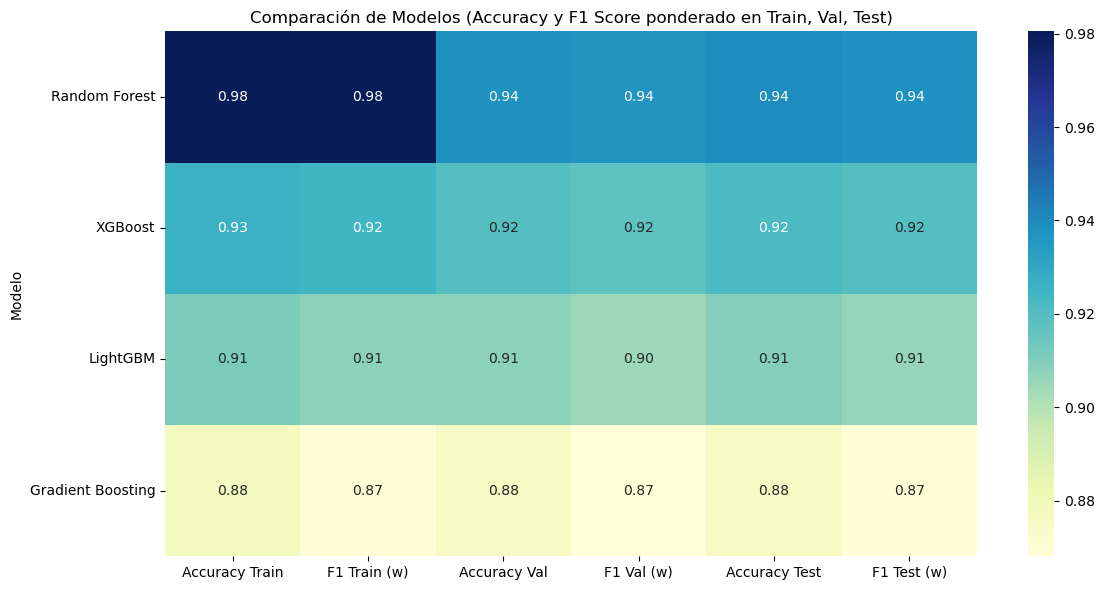

In [209]:
# Visualización con heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_resultados.set_index('Modelo'), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Comparación de Modelos (Accuracy y F1 Score ponderado en Train, Val, Test)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<p><em>A primera vista RandomForest parece tener las mejores m&eacute;tricas en los 3 subconjuntos, pero me genera algunas dudas, as&iacute; que generar&eacute; un reporte m&aacute;s completo de m&eacute;tricas.&nbsp;</em></p>


In [210]:
for nombre, modelo in modelos_entrenados.items():
    # Predicciones
    y_train_pred = modelo.predict(X_train)
    y_val_pred = modelo.predict(X_val)
    y_test_pred = modelo.predict(X_test)
    print(f"\n Nombre del modelo:  {nombre}")
    print(f"\n🧾 Reporte de clasificación Entrenamiento:\n{classification_report(y_train_pred, y_train)}")
    print(f"\n🧾 Reporte de clasificación Evaluacion:\n{classification_report(y_val_pred, y_val)}")
    print(f"\n🧾 Reporte de clasificación Prueba:\n{classification_report(y_test_pred, y_test)}")


 Nombre del modelo:  Random Forest

🧾 Reporte de clasificación Entrenamiento:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    287093
           1       0.94      0.98      0.96     89460
           2       0.91      0.99      0.95      2620

    accuracy                           0.98    379173
   macro avg       0.95      0.98      0.96    379173
weighted avg       0.98      0.98      0.98    379173


🧾 Reporte de clasificación Evaluacion:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     96519
           1       0.85      0.91      0.88     29260
           2       0.47      0.73      0.57       612

    accuracy                           0.94    126391
   macro avg       0.76      0.86      0.80    126391
weighted avg       0.94      0.94      0.94    126391


🧾 Reporte de clasificación Prueba:
              precision    recall  f1-score   support

           0       0.97     

<p class="" data-start="275" data-end="668"><strong>Conclusi&oacute;n:</strong>&nbsp;</p>
<p class="" data-start="275" data-end="668">En este estudio se evalu&oacute; el desempe&ntilde;o de cuatro algoritmos de clasificaci&oacute;n supervisada (Random Forest, Gradient Boosting, XGBoost y LightGBM) sobre el conjunto de datos CICAAGM, el cual fue construido a partir de aplicaciones Android ejecutadas en dispositivos reales para capturar comportamiento realista, especialmente dise&ntilde;ado para evadir t&eacute;cnicas anti-an&aacute;lisis como el uso de emuladores.</p>
<p class="" data-start="670" data-end="827">Los modelos fueron entrenados y evaluados utilizando tres subconjuntos (entrenamiento, validaci&oacute;n y prueba), y se observaron los siguientes resultados clave:</p>
<ul data-start="829" data-end="1674">
<li class="" data-start="829" data-end="1133">
<p class="" data-start="831" data-end="1133"><strong data-start="831" data-end="848">Random Forest</strong> logr&oacute; el mejor rendimiento general, alcanzando una precisi&oacute;n y F1 Score ponderado de aproximadamente 0.94 en los conjuntos de validaci&oacute;n y prueba. Adem&aacute;s, demostr&oacute; una capacidad s&oacute;lida para identificar correctamente todas las clases, incluyendo la clase minoritaria (malware general).</p>
</li>
<li class="" data-start="1137" data-end="1455">
<p class="" data-start="1139" data-end="1455"><strong data-start="1139" data-end="1150">XGBoost</strong> y <strong data-start="1153" data-end="1165">LightGBM</strong> mostraron un rendimiento competitivo, especialmente en precisi&oacute;n y recall para las clases de adware y malware, aunque ligeramente por debajo de Random Forest. Estos modelos tambi&eacute;n destacaron por su capacidad para generalizar, manteniendo resultados consistentes en todos los subconjuntos.</p>
</li>
<li class="" data-start="1457" data-end="1674">
<p class="" data-start="1459" data-end="1674"><strong data-start="1459" data-end="1480">Gradient Boosting</strong>, aunque &uacute;til, mostr&oacute; menor desempe&ntilde;o relativo, especialmente al diferenciar entre las clases 1 (adware) y 2 (malware general), presentando menor F1 score y mayores confusiones entre las clases.</p>
</li>
</ul>


## 6. Optimizar Mejor Modelo

### Balancear random Forest

<p><em>Se tratar&aacute; de balancear los modelos para buscar mejores resultados en el subconjunto de validaci&oacute;n y prueba.&nbsp;&nbsp;</em></p>

In [211]:
RF_balanceado = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced' )
RF_balanceado.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [212]:
y_train_pred = RF_balanceado.predict(X_train)
y_val_pred = RF_balanceado.predict(X_val)
y_test_pred = RF_balanceado.predict(X_test)

In [213]:
print(f"\n🧾 Reporte de clasificación (Entrenamiento):\n{classification_report(y_train_pred, y_train)}")
print(f"\n🧾 Reporte de clasificación (Validacion) :\n{classification_report(y_val_pred, y_val)}")
print(f"\n🧾 Reporte de clasificación (Prueba):\n{classification_report(y_test_pred, y_test)}")


🧾 Reporte de clasificación (Entrenamiento):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    275105
           1       0.98      0.92      0.95     99156
           2       0.97      0.56      0.71      4912

    accuracy                           0.97    379173
   macro avg       0.97      0.83      0.88    379173
weighted avg       0.97      0.97      0.97    379173


🧾 Reporte de clasificación (Validacion) :
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     92748
           1       0.89      0.86      0.87     32235
           2       0.50      0.34      0.41      1408

    accuracy                           0.93    126391
   macro avg       0.78      0.72      0.74    126391
weighted avg       0.92      0.93      0.93    126391


🧾 Reporte de clasificación (Prueba):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     92712
   

<p class="" data-start="721" data-end="1075"><strong>Conclusi&oacute;n:&nbsp;</strong></p>

Tras evaluar varios algoritmos de clasificación sobre el conjunto de datos CICAAGM, el modelo Random Forest original sin ajuste de pesos mostró el mejor rendimiento global. Aunque se probó una versión balanceada para mejorar la detección de clases minoritarias, dicha modificación redujo el desempeño general del modelo, especialmente en los subconjuntos de validación y prueba.

El modelo original logró una precisión del 93.9% y un F1-score ponderado de 93.8% en el conjunto de prueba, con una destacada capacidad para detectar tanto aplicaciones benignas como maliciosas, incluyendo un buen desempeño sobre la clase minoritaria. Por lo tanto, se concluye que la versión sin balanceo de Random Forest es la opción más adecuada para este caso, ya que mantiene un equilibrio óptimo entre precisión, recall y generalización.


### Otra alternativa: LightGBM

In [214]:
# Suponiendo que y_train tiene valores como strings: '0', '1', '2'
# y que la clase minoritaria es '2'
n_total = len(y_train)
n_pos = np.sum(y_train == 2)  # Clase minoritaria
n_neg = n_total - n_pos

scale_pos_weight = n_neg / n_pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")


scale_pos_weight: 132.18


In [215]:
#Creamos los modelos, el primero con Scale_pos_weight y el segundo  con class_weigth = "Balanced"
Ligth_Scale = LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_estimators=100)
Ligth_Aut = LGBMClassifier(class_weight='balanced', random_state=42, n_estimators=100)

In [216]:
#Entrenamos los modelos
Ligth_Scale.fit(X_train, y_train)
Ligth_Aut.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 379173, number of used features: 38
[LightGBM] [Info] Start training from score -0.292694
[LightGBM] [Info] Start training from score -1.401444
[LightGBM] [Info] Start training from score -4.891727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 379173, number of used features: 38
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(class_weight='balanced', random_state=42)

In [217]:
# Prediccion sobre el  subconjunto de entrenamiento
y_pred_Scale =Ligth_Scale.predict(X_train)
y_pred_Aut = Ligth_Aut.predict(X_train)

Modelo Ajustando la clase Desbalanceada (Entrenamiento) 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94    282958
           1       0.88      0.75      0.81     93368
           2       0.84      0.45      0.58      2847

    accuracy                           0.91    379173
   macro avg       0.88      0.72      0.78    379173
weighted avg       0.91      0.91      0.91    379173



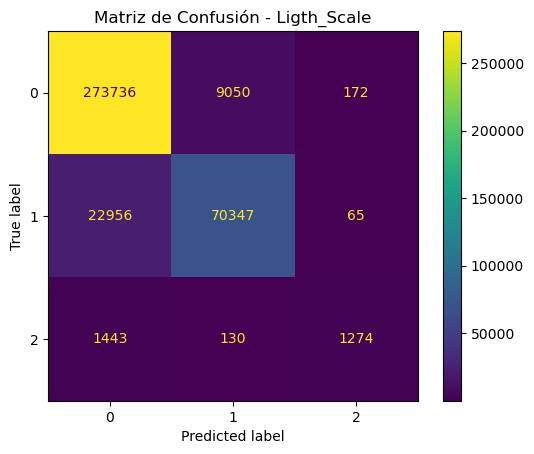

Modelo Ajustando automaticamente la clase Desbalanceada (Entrenamiento) 
              precision    recall  f1-score   support

           0       0.97      0.80      0.88    282958
           1       0.71      0.89      0.79     93368
           2       0.09      0.91      0.16      2847

    accuracy                           0.82    379173
   macro avg       0.59      0.87      0.61    379173
weighted avg       0.90      0.82      0.85    379173



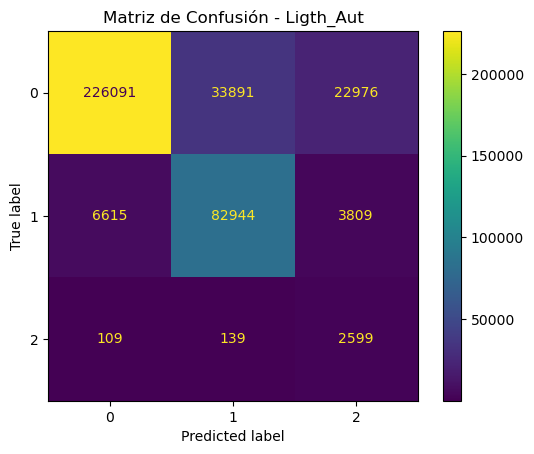

In [218]:
#Evaluacion de modelos

print("Modelo Ajustando la clase Desbalanceada (Entrenamiento) ")
print(classification_report(y_train, y_pred_Scale, target_names=['0', '1', '2']))
disp1 = ConfusionMatrixDisplay.from_estimator(Ligth_Scale, X_train, y_train, values_format='d')
plt.title("Matriz de Confusión - Ligth_Scale")
plt.show()

print("Modelo Ajustando automaticamente la clase Desbalanceada (Entrenamiento) ")
print(classification_report(y_train, y_pred_Aut, target_names=['0', '1', '2']))
disp2 = ConfusionMatrixDisplay.from_estimator(Ligth_Aut, X_train, y_train, values_format='d')
plt.title("Matriz de Confusión - Ligth_Aut")
plt.show()


In [219]:
#Prediccion con el subconjunto de validacion
y_pred_Scale =Ligth_Scale.predict(X_val)
y_pred_Aut = Ligth_Aut.predict(X_val)

Modelo ajustando manualmente la clase desbalanceada (Validacion) 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     94319
           1       0.88      0.75      0.81     31123
           2       0.78      0.41      0.54       949

    accuracy                           0.91    126391
   macro avg       0.86      0.71      0.76    126391
weighted avg       0.91      0.91      0.90    126391



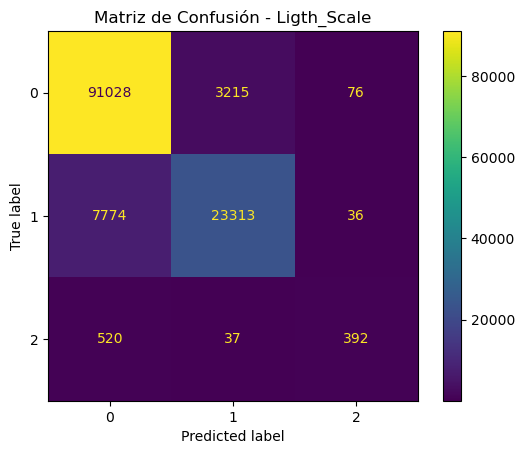

Modelo ajustando automáticamente la clase desbalanceada (Validacion) 
              precision    recall  f1-score   support

           0       0.97      0.80      0.87     94319
           1       0.71      0.88      0.78     31123
           2       0.08      0.79      0.14       949

    accuracy                           0.82    126391
   macro avg       0.58      0.82      0.60    126391
weighted avg       0.90      0.82      0.85    126391



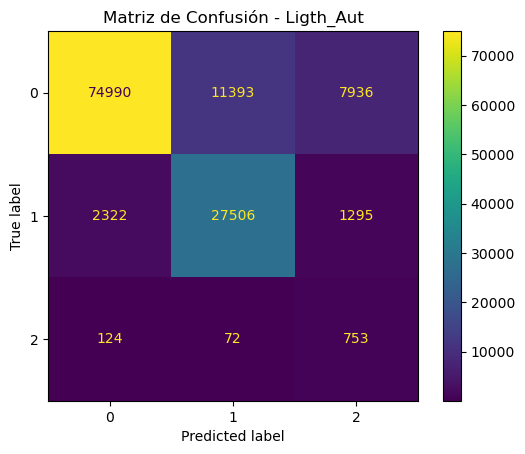

In [220]:
#Evaluacion de Modelos

# Evaluación del modelo Ligth_Scale
print("Modelo ajustando manualmente la clase desbalanceada (Validacion) ")
print(classification_report(y_val, y_pred_Scale, target_names=['0', '1', '2']))
disp1 = ConfusionMatrixDisplay.from_estimator(Ligth_Scale, X_val, y_val, values_format='d')
plt.title("Matriz de Confusión - Ligth_Scale")
plt.show()

# Evaluación del modelo Ligth_Aut
print("Modelo ajustando automáticamente la clase desbalanceada (Validacion) ")
print(classification_report(y_val, y_pred_Aut, target_names=['0', '1', '2']))
disp2 = ConfusionMatrixDisplay.from_estimator(Ligth_Aut, X_val, y_val, values_format='d')
plt.title("Matriz de Confusión - Ligth_Aut")
plt.show()


<p class="" data-start="721" data-end="1075"><strong>Conclusi&oacute;n:&nbsp;</strong></p>

Se evaluaron dos enfoques para abordar el desbalance de clases en el modelo LightGBM: uno ajustando manualmente el parámetro scale_pos_weight, y otro utilizando el ajuste automático con class_weight='balanced'.

Los resultados indican que el modelo ajustado manualmente con scale_pos_weight=132.18 ofrece un mejor equilibrio general entre precisión y recall, especialmente para la clase minoritaria (clase 2). Aunque su rendimiento en términos de precisión no alcanza los niveles del modelo automático en la clase 0, logra una mayor estabilidad y f1-score para la clase 2 en los subconjuntos de entrenamiento y validación. Esto refleja una mejor capacidad para identificar correctamente los casos menos representados.

Por otro lado, el modelo con class_weight='balanced' muestra un comportamiento inestable: aunque alcanza un recall muy alto para la clase minoritaria, su precisión es extremadamente baja, lo cual deriva en un f1-score pobre. Además, tiende a sobredetectar la clase 2, lo que reduce la calidad general de las predicciones.

En conclusión, el modelo con ajuste manual (scale_pos_weight) es preferible para esta tarea, ya que mantiene una buena precisión global y mejora significativamente el rendimiento sobre la clase menos representada sin comprometer el desempeño en las demás clases.


### Ajustar el threshold de predicción para clase

Ajustando el threshold del modelo que lleva scale_pos_weight

In [222]:
thresholds = np.arange(0.3, 0.81, 0.05)  # desde 0.3 hasta 0.8 en pasos de 0.05

def predict_with_threshold(probs, threshold=0.6, clase_especial=2):
    predicciones = []
    for p in probs:
        if p[clase_especial] >= threshold:
            predicciones.append(clase_especial)
        else:
            p_temp = p.copy()
            p_temp[clase_especial] = -1
            predicciones.append(np.argmax(p_temp))
    return np.array(predicciones)

In [226]:
#
proba_Aut_train = Ligth_Scale.predict_proba(X_train)
proba_Aut = Ligth_Scale.predict_proba(X_val)
proba_Aut_test = Ligth_Scale.predict_proba(X_test)

best_threshold = None
best_f1 = 0

for t in thresholds:
    y_pred = predict_with_threshold(proba_Aut, threshold=t)
    f1 = f1_score(y_val, y_pred, labels=[2], average='macro')
    print(f"Threshold: {t:.2f} — F1 clase 2: {f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\nMejor threshold para clase 2: {best_threshold:.2f} con F1: {best_f1:.3f}")

Threshold: 0.30 — F1 clase 2: 0.540
Threshold: 0.35 — F1 clase 2: 0.544
Threshold: 0.40 — F1 clase 2: 0.544
Threshold: 0.45 — F1 clase 2: 0.538
Threshold: 0.50 — F1 clase 2: 0.533
Threshold: 0.55 — F1 clase 2: 0.529
Threshold: 0.60 — F1 clase 2: 0.524
Threshold: 0.65 — F1 clase 2: 0.516
Threshold: 0.70 — F1 clase 2: 0.500
Threshold: 0.75 — F1 clase 2: 0.497
Threshold: 0.80 — F1 clase 2: 0.489

Mejor threshold para clase 2: 0.40 con F1: 0.544


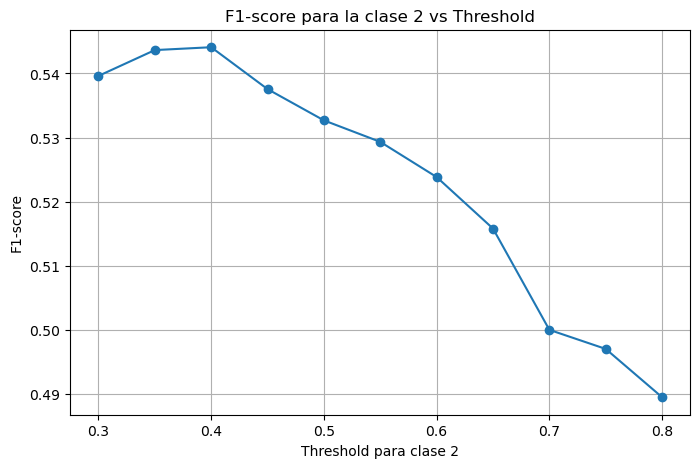

In [224]:
f1_scores = []

for t in thresholds:
    y_pred = predict_with_threshold(proba_Aut, threshold=t)
    f1 = f1_score(y_val, y_pred, labels=[2], average='macro')
    f1_scores.append(f1)

plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1-score para la clase 2 vs Threshold')
plt.xlabel('Threshold para clase 2')
plt.ylabel('F1-score')
plt.grid(True)
plt.show()

In [227]:
# Evaluar con el mejor threshold encontrado entrenamiento
y_pred_best_train = predict_with_threshold(proba_Aut_train, threshold=best_threshold)
print("\nReporte con el mejor threshold con datos de entrenamiento:")
print(classification_report(y_train, y_pred_best_train, target_names=['0', '1', '2']))
print(confusion_matrix(y_train, y_pred_best_train))

# Evaluar con el mejor threshold encontrado validacion 
y_pred_best = predict_with_threshold(proba_Aut, threshold=best_threshold)
print("\nReporte con el mejor threshold con datos de validacion :")
print(classification_report(y_val, y_pred_best, target_names=['0', '1', '2']))
print(confusion_matrix(y_val, y_pred_best))

# Evaluar con el mejor threshold encontrado Prueba 
y_pred_best_test = predict_with_threshold(proba_Aut_test, threshold=best_threshold)
print("\nReporte con el mejor threshold con datos de Prueba :")
print(classification_report(y_test, y_pred_best_test, target_names=['0', '1', '2']))
print(confusion_matrix(y_test, y_pred_best_test))


Reporte con el mejor threshold con datos de entrenamiento:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94    282958
           1       0.88      0.75      0.81     93368
           2       0.84      0.47      0.60      2847

    accuracy                           0.91    379173
   macro avg       0.88      0.73      0.79    379173
weighted avg       0.91      0.91      0.91    379173

[[273723   9050    185]
 [ 22956  70351     61]
 [  1379    131   1337]]

Reporte con el mejor threshold con datos de validacion :
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     94319
           1       0.88      0.75      0.81     31123
           2       0.76      0.42      0.54       949

    accuracy                           0.91    126391
   macro avg       0.85      0.71      0.76    126391
weighted avg       0.91      0.91      0.90    126391

[[91016  3215    88]
 [ 7773 23314    36]
 [  5

<p data-start="241" data-end="748"><strong>Conclusi&oacute;n:&nbsp;</strong></p>
<p data-start="241" data-end="748">Tras ajustar el umbral de decisi&oacute;n del modelo LightGBM entrenado con scale_pos_weight, se logr&oacute; una mejora notable en la identificaci&oacute;n de la clase 2 (minoritaria), alcanzando un F1-score de 0.54 en el conjunto de validaci&oacute;n, comparado con el 0.47 obtenido por el modelo sin ajuste de threshold. Esta optimizaci&oacute;n permiti&oacute; elevar el recall de la clase 2 de 29% a 42%, y su precisi&oacute;n de 69% a 76%, lo que refleja un mejor equilibrio entre falsos positivos y falsos negativos para esa clase.</p>
<p data-start="750" data-end="1164">En general, aunque el accuracy total se mantuvo en torno al 91%, se obtuvo una mayor representatividad para la clase 2 sin sacrificar el rendimiento de las clases mayoritarias. Este resultado supera tanto al modelo LightGBM balanceado por defecto como al Random Forest balanceado, que mostraron menor capacidad de detecci&oacute;n para la clase minoritaria (con F1-scores de 0.47 y 0.41 respectivamente para clase 2).</p>
<p data-start="1166" data-end="1436">Por tanto, el modelo LightGBM con scale_pos_weight y ajuste de umbral (threshold = 0.40) representa hasta ahora la mejor alternativa para el problema, al ofrecer un rendimiento global robusto y una considerable mejora en la sensibilidad hacia la clase minoritaria.</p>


<h3 class="" data-start="81" data-end="141">An&aacute;lisis Comparativo y Conclusi&oacute;n sobre Modelos Probados</h3>


<p data-start="241" data-end="748"><strong>Conclusi&oacute;n:&nbsp;</strong></p>
<p data-start="178" data-end="389">Al comparar el modelo LightGBM con scale_pos_weight y ajuste de umbral (threshold = 0.40) frente al Random Forest original, se observan diferencias importantes en su desempe&ntilde;o dependiendo del objetivo.</p>
<p data-start="391" data-end="809">El modelo Random Forest original mostr&oacute; un desempe&ntilde;o general fuerte, con una alta precisi&oacute;n y recall en las clases mayoritarias (0 y 1), alcanzando un accuracy global del 93%. Sin embargo, su capacidad para detectar la clase minoritaria (clase 2) fue limitada, con un F1-score de 0.37 en el conjunto de prueba y un recall bajo (24%), lo que indica que tiende a pasar por alto muchos casos de esa clase.</p>
<p data-start="811" data-end="1197">En cambio, el modelo LightGBM con threshold ajustado mantuvo un accuracy similar (91%), pero mejor&oacute; significativamente la identificaci&oacute;n de la clase 2. Su F1-score en prueba para esta clase fue de 0.54, con un recall del 40%, lo que representa una mejora clara en la detecci&oacute;n de la clase minoritaria, sin comprometer excesivamente el rendimiento sobre las dem&aacute;s clases.</p>


<h3 class="" data-start="1984" data-end="2014">Conclusi&oacute;n Final</h3>

<p data-start="1199" data-end="1237">Recomendaci&oacute;n por circunstancia:</p>
<ul data-start="1239" data-end="1690">
<li data-start="1239" data-end="1397">
<p data-start="1241" data-end="1397">Si el objetivo es maximizar la precisi&oacute;n global y se da mayor importancia a las clases mayoritarias, el Random Forest original es una opci&oacute;n s&oacute;lida.</p>
</li>
<li data-start="1398" data-end="1690">
<p data-start="1400" data-end="1690">Si el objetivo es detectar correctamente la clase minoritaria (clase 2) &mdash;por ejemplo, si representa un caso cr&iacute;tico o de riesgo&mdash;, el LightGBM con threshold ajustado es claramente superior, ya que mejora la sensibilidad hacia esa clase sin perder consistencia en el resto del modelo.</p>
</li>
</ul>
<p data-start="1692" data-end="1919">En resumen, para este ejercicio, LightGBM con threshold ajustado ofrece un balance m&aacute;s adecuado entre rendimiento global y detecci&oacute;n espec&iacute;fica, siendo la opci&oacute;n preferible cuando se requiere una mayor equidad entre clases.</p>